In [ ]:
# default_exp models.cox

# Cox Proportional Hazard
> SA with features apart from time

$$
\begin{align}
\lambda(t,x) = \lambda(t)h(x)
\end{align}
$$

In [ ]:
# export
from torchlife.models.ph import PieceWiseHazard
from torchlife.losses import hazard_loss

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# torch.Tensor.ndim = property(lambda x: x.dim())

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

$$
\begin{align}
\int_0^T \lambda(t,x) dt &= \int_0^T \lambda(t)h(x) dt\\
&= h(x)\int_0^T \lambda(t) dt
\end{align}
$$

In [ ]:
# export
class ProportionalHazard(nn.Module):
    """
    Hazard proportional to time and feature component as shown above.
    parameters:
    - breakpoints: time points where hazard would change
    - max_t: maximum point of time to plot to.
    - dim: number of input dimensions of x
    - h: (optional) number of hidden units (for x only).
    """
    def __init__(self, breakpoints, max_t, dim, h=()):
        super().__init__()
        self.baseλ = PieceWiseHazard(breakpoints, max_t)
        nodes = (dim,) + h + (1,)
        self.layers = nn.ModuleList([nn.Linear(a,b, bias=False) 
                                   for a,b in zip(nodes[:-1], nodes[1:])])
        
    def forward(self, t, t_section, x):
        logλ, Λ = self.baseλ(t, t_section)
        
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        log_hx = self.layers[-1](x)
        
        logλ += log_hx
        Λ = torch.exp(log_hx + torch.log(Λ))
        return logλ, Λ
    
    def survival_function(self, t, x):
        with torch.no_grad():
            x = torch.Tensor(x)
            if len(x.shape) < 2:
                x = x[None, :]
            # get the times and time sections for survival function
            breakpoints = self.baseλ.breakpoints[1:].cpu().numpy()
            t_sec_query = np.searchsorted(breakpoints, t)
            # convert to pytorch tensors
            t_query = torch.Tensor(t)[:,None]
            t_sec_query = torch.LongTensor(t_sec_query)

            # calculate cumulative hazard according to above
            _, Λ = self.forward(t_query, t_sec_query, x)
            return torch.exp(-Λ)
            
    
    def plot_survival_function(self, t, x):
        s = self.survival_function(t, x)
        
        # plot
        plt.figure(figsize=(12,5))
        plt.plot(t, s)
        plt.xlabel('Time')
        plt.ylabel('Survival Probability')
        plt.show()

## Fitting Cox Proportional Hazard Model

In [ ]:
# hide
from torchlife.data import create_db
import pandas as pd

In [ ]:
# hide
url = "https://raw.githubusercontent.com/CamDavidsonPilon/lifelines/master/lifelines/datasets/rossi.csv"
df = pd.read_csv(url)
df.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [ ]:
# hide
df.rename(columns={'week':'t', 'arrest':'e'}, inplace=True)

event_times = df.loc[df['e']==1, 't'].values
breakpoints = np.percentile(event_times, [20, 40, 60, 80])
print(breakpoints)

db = create_db(df, breakpoints)

[14.6 24.  35.  43.4]


epoch,train_loss,valid_loss,time
0,285.135498,#na#,00:00
1,286.225586,#na#,00:00
2,285.599548,#na#,00:00
3,286.237213,#na#,00:00
4,287.246368,#na#,00:00
5,286.796509,#na#,00:00
6,286.854156,#na#,00:00
7,286.426819,#na#,00:00
8,286.480560,#na#,00:00
9,286.555298,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


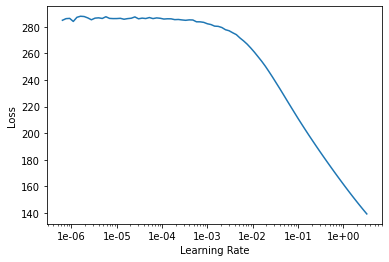

In [ ]:
# hide
from fastai.basics import Learner

x_dim = df.shape[1] - 2
model = ProportionalHazard(breakpoints, df['t'].max(), x_dim, h=(3,3))
learner = Learner(db, model, loss_func=hazard_loss)
# wd = 1e-4
learner.lr_find()
learner.recorder.plot()

In [ ]:
# hide
epochs = 10
learner.fit(epochs, lr=1)

epoch,train_loss,valid_loss,time
0,107.796844,6.634949,00:00
1,54.736313,2.906182,00:00
2,36.204514,2.217191,00:00
3,26.801949,2.058458,00:00
4,21.149914,2.025760,00:00
5,17.385147,2.023441,00:00
6,14.712727,2.025011,00:00
7,12.699509,2.022849,00:00
8,11.151483,2.016688,00:00
9,9.919215,2.007591,00:00


## Plotting hazard functions

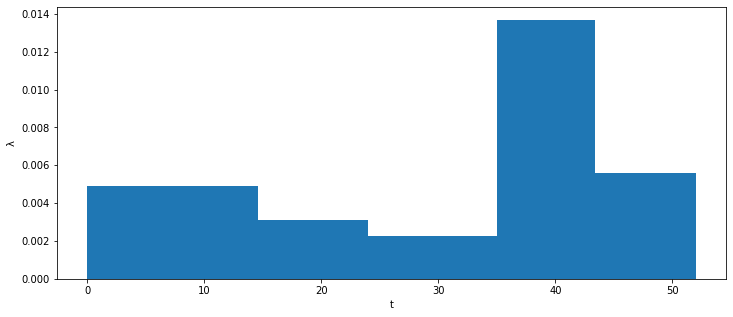

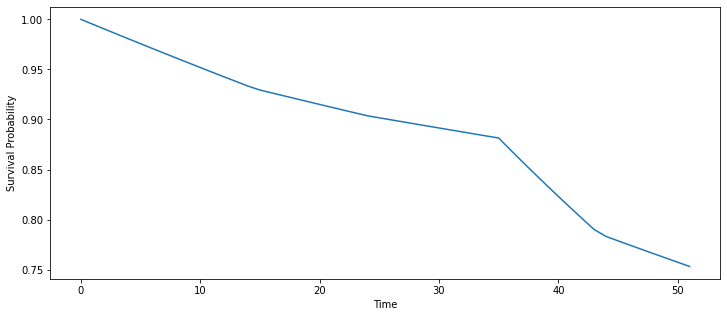

In [ ]:
model.baseλ.plot_hazard()
x = df.drop(['t', 'e'], axis=1).iloc[4]
t = np.arange(df['t'].max())
model.plot_survival_function(t, x)

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_index.ipynb.
Converted 80_data.ipynb.
Converted 90_model.ipynb.
Converted 95_Losses.ipynb.
Converted AFT_error_distributions.ipynb.
Converted AFT_models.ipynb.
Converted KaplanMeier.ipynb.
Converted SAT.ipynb.
Converted hazard.Cox.ipynb.
Converted hazard.PiecewiseHazard.ipynb.
Converted hazard.ipynb.
